<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/NER_Hakcathon_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super AI Season 3 Named-entity-recognition Hackathon
LST20 Dataset

Prerequisite
Following files: 
- `ne_test.txt`
- `AIFORTHAI-LST20Corpus.tar.gz`
- `ne_sample_submission.csv`

Hackathon link: https://www.kaggle.com/competitions/ss3-hackathon-online-natural-language-processing

### Q: Is this the code I used to get Rank 3 on private scoreboard?
A: No, That high score is obtain by [Ensemble Method](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205) of three Bert models and not worth sharing at all!

### Q: Then How much score you get with this code?
A: 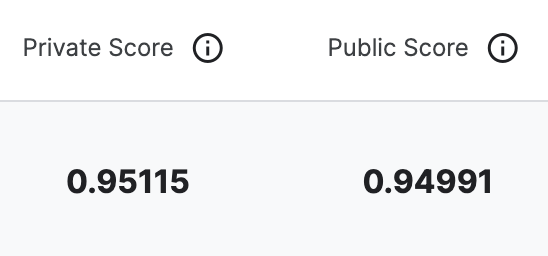

A: Around 0.95 Micro F1 Score. Little bit lower than Finetuning Bert model (0.96) but with **just 3 Millions parameters** compare to Bert with 100 Millions at minimum.

## Install, Import, and Extract files

In [ ]:
!pip install datasets pythainlp python-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 8.6 MB/s 
     |████████████████████████████████| 965 kB 59.9 MB/s 


In [ ]:
!tar -xf AIFORTHAI-LST20Corpus.tar.gz

In [ ]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import tensorflow as tf

In [ ]:
dataset = load_dataset("lst20", data_dir='/content/LST20_Corpus')

  0%|          | 0/3 [00:00<?, ?it/s]

## Load Dataset

In [ ]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])

## Preprocess Data

In [ ]:
"""Pad Sequences"""
max_len = 256  # Sequence length to pad the outputs to.
y_train = tf.keras.preprocessing.sequence.pad_sequences(df_train['ner_tags'], maxlen=max_len, padding='post', truncating='post')
y_val = tf.keras.preprocessing.sequence.pad_sequences(df_val['ner_tags'], maxlen=max_len, padding='post', truncating='post')

X_train = df_train['tokens'].tolist()
X_val = df_val['tokens'].tolist()

In [ ]:
"""Create Token Dictionary"""
count = 1
dictionary = {}
for item in X_train:
  for token in item:
    if token not in dictionary.keys():
      dictionary[token] = count
      count += 1
unknown_count = count + 1

In [ ]:
len(dictionary)

48945

In [ ]:
"""Intentionally remove 1% of Vocab to teach model how to handle unknown vocabulary"""
import random
for i in range(int(len(dictionary) * 0.01)):
    dictionary.pop( random.choice(list(dictionary.keys())))

In [ ]:
len(dictionary)

48456

In [ ]:
def to_token(array):
  result = []
  for item in array:
    tokenized_text = []
    for token in item:
      if token in dictionary.keys():
        tokenized_text.append(dictionary[token])
      else:
        tokenized_text.append(unknown_count)
    result.append(tokenized_text)
  return result

In [ ]:
"""Convert Text to tokenized data"""
X_train = to_token(X_train)
X_val = to_token(X_val)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((63310, 256), (5620, 256), (63310, 256), (5620, 256))

## Modeling

In [ ]:
# create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.layers as layers
from tensorflow.keras import Model, Input

max_review_length = max_len
embedding_vecor_length = 64
vocab_size = 50000

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

input = tf.keras.Input(shape=(max_review_length,))
x = Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length, mask_zero=True)(input)
x = layers.Bidirectional(LSTM(64, input_shape=(max_review_length, embedding_vecor_length), dropout=0.1, return_sequences=True))(x)
kernel = layers.TimeDistributed(Dense(31, activation='softmax'))(x)

model = Model(input, kernel)


model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 256, 64)           3200000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         66048     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 256, 31)          3999      
 tributed)                                                       
                                                                 
Total params: 3,270,047
Trainable params: 3,270,047
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
"""Text predict"""
model.predict(X_train[:10]).shape

1/1 [==============================] - 2s 2s/step


(10, 256, 31)

In [ ]:
checkpoint_filepath = './checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=1024, callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

Epoch 1/30
62/62 [==============================] - 17s 140ms/step - loss: 0.2675 - accuracy: 0.8181 - val_loss: 0.1841 - val_accuracy: 0.8056
Epoch 2/30
62/62 [==============================] - 7s 116ms/step - loss: 0.1522 - accuracy: 0.8329 - val_loss: 0.1596 - val_accuracy: 0.8056
Epoch 3/30
62/62 [==============================] - 6s 96ms/step - loss: 0.1206 - accuracy: 0.8337 - val_loss: 0.1318 - val_accuracy: 0.8080
Epoch 4/30
62/62 [==============================] - 5s 88ms/step - loss: 0.1002 - accuracy: 0.8432 - val_loss: 0.1198 - val_accuracy: 0.8197
Epoch 5/30
62/62 [==============================] - 6s 92ms/step - loss: 0.0889 - accuracy: 0.8581 - val_loss: 0.1097 - val_accuracy: 0.8324
Epoch 6/30
62/62 [==============================] - 6s 89ms/step - loss: 0.0774 - accuracy: 0.8735 - val_loss: 0.0970 - val_accuracy: 0.8515
Epoch 7/30
62/62 [==============================] - 5s 89ms/step - loss: 0.0638 - accuracy: 0.8992 - val_loss: 0.0820 - val_accuracy: 0.8788
Epoch 8/30

In [ ]:
y_pred = model.predict(X_val)

176/176 [==============================] - 2s 9ms/step


In [ ]:
import numpy as np

In [ ]:
y_pred_max = np.argmax(y_pred, 2)
y_pred_max_masked = y_pred_max[X_val != 0]
y_val_max_masked = y_val[X_val != 0]

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_val_max_masked, y_pred_max_masked, average='micro')

0.9354145806414086

## Preprocess Test Data

In [ ]:
from pythainlp.tokenize import clause_tokenize

In [ ]:
lst_20_test = []
with open(f"ne_test.txt", "r") as file:
    file_read = file.readlines()
    for line in file_read:
      if len(line.strip()) == 0:
        lst_20_test.append('_')
      else:
        lst_20_test.append(line.strip().replace('\xa0', ''))

lst_20_test = lst_20_test[:-1]

In [ ]:
lst_20_test_tokenized = clause_tokenize(lst_20_test)

/usr/local/lib/python3.7/dist-packages/pythainlp/tokenize/crfcls.py:63: UserWarning: 
    LST20 corpus are free for research and open source only.

    If you want to use in Commercial use, please contract NECTEC.

    https://www.facebook.com/dancearmy/posts/10157641945708284
    
  """)
/usr/local/lib/python3.7/dist-packages/pythainlp/tag/perceptron.py:47: UserWarning: 
    LST20 corpus are free for research and open source only.

    If you want to use in Commercial use, please contract NECTEC.

    https://www.facebook.com/dancearmy/posts/10157641945708284
    
  """


In [ ]:
X_test = to_token(lst_20_test_tokenized)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [ ]:
(X_test != 0).sum()

69561

## Predict and Submit Test Data

In [ ]:
y_test_pred = model.predict(X_test)

114/114 [==============================] - 1s 8ms/step


In [ ]:
y_test_pred.shape

(3648, 256, 31)

In [ ]:
y_test_pred_max = np.argmax(y_test_pred, 2)
y_test_pred_max_masked = y_test_pred_max[X_test != 0]

In [ ]:
len(y_test_pred_max_masked)

69561

In [ ]:
df_submit = pd.read_csv('/content/ne_sample_submission.csv')
df_submit

,Id,Predicted
0,1,B_TTL
1,2,B_PER
2,3,I_PER
3,4,NaN
4,5,NaN
...,...,...
69556,69557,NaN
69557,69558,NaN
69558,69559,NaN
69559,69560,NaN


In [ ]:
y_test_pred_max_masked

array([10,  8, 18, ...,  0,  0,  0])

In [ ]:
df_submit['Predicted'] = pd.Series(y_test_pred_max_masked)

In [ ]:
ner_list = ['O', 'B_BRN', 'B_DES', 'B_DTM', 'B_LOC', 'B_MEA', 'B_NUM', 'B_ORG', 'B_PER', 'B_TRM', 'B_TTL', 'I_BRN', 'I_DES', 'I_DTM', 'I_LOC', 'I_MEA', 'I_NUM', 'I_ORG', 'I_PER', 'I_TRM', 'I_TTL', 'E_BRN', 'E_DES', 'E_DTM', 'E_LOC', 'E_MEA', 'E_NUM', 'E_ORG', 'E_PER', 'E_TRM', 'E_TTL']

In [ ]:
df_submit['Predicted'] = df_submit['Predicted'].apply(lambda x: ner_list[x])

In [ ]:
df_submit

,Id,Predicted
0,1,B_TTL
1,2,B_PER
2,3,I_PER
3,4,E_PER
4,5,O
...,...,...
69556,69557,O
69557,69558,O
69558,69559,O
69559,69560,O


In [ ]:
df_submit.to_csv('df_submit_lstm.csv', index = False)